# Air Pollution by Politics

## Imports & Installs

In [1]:
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, explained_variance_score

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.signal import argrelextrema

sys.path.append('../etc')
from refs import state_abbreviation_dict

!pip install kneed
!pip install -q xlrd openpyxl


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Loads

Since the `data` folder is approximately **14 GB**, it has been uploaded to a **shared Google Drive folder**.
To access and use this data in this notebook, follow these steps:

---

### 1. Upload this notebook to **Google Colab**
- Open [Google Colab](https://colab.research.google.com/).
- Click on **File → Upload notebook** and select this notebook.

### 2. Mount your Google Drive
Insert and run the following code in a new Colab cell:

```python
from google.colab import drive
drive.mount('/content/drive')
```
- This will prompt you to authorize access to your Google Drive.

### 3. Create a Shortcut of the `data` Folder in Your Google Drive
- Open the shared Google Drive link.
- **Right-click** the `data` folder → **Add shortcut to Drive**.
- Choose a location inside your **MyDrive** (e.g., directly under "MyDrive" or inside a project folder).

### 4. Update the File Paths in the Notebook
When reading the data files, adjust the paths in your code to point to your shortcut location.
For example:

```python
import pandas as pd

# Example
presidential_data = pd.read_csv('/content/drive/MyDrive/your_folder_name/data/election/relevant/usa/1976-2020-president.csv')
```

Replace `your_folder_name` with the actual folder name where you added the shortcut.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# presidential_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-president.csv')
# senate_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-senate.csv')
# house_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2022-house.csv')
# house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')
#
# state_emissions_data = pd.read_excel(
#     "/content/drive/MyDrive/School/data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
#     engine="openpyxl",
#     skiprows=4
# )
#
# state_population_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/population_data.csv')
# state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
# state_land_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/state_sizes.csv')

In [4]:
presidential_data = pd.read_csv('../data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('../data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('../data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "../data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)

state_population_size_data = pd.read_csv('../data/general_state_data/population_data.csv')
state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
state_land_size_data = pd.read_csv('../data/general_state_data/state_sizes.csv')

##  Analysis Per Category

### Election Analysis

This code calculates a political score for each U.S. state based on presidential, House, and Senate election data. It processes the election data for each year, calculates political scores by considering factors like vote percentage, longest streak of party wins, and the party of the most recent winner. It then combines these scores using weighted averages for each state and year. The final political scores are scaled and adjusted using the `MinMaxScaler`, and the scores are returned in a DataFrame, where each row represents a state’s political score for a specific year. This method provides insights into state-level political trends over time.

In [5]:
def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']
    df_summary['year'] = year
    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

final_political_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)
final_political_scores_by_year = final_political_scores_by_year.rename(columns={'final_score_avg':'party_affiliation_score'})
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


### Emissions Analysis

This code analyzes state-level emissions data by excluding any rows containing "Total" in the state name. It then calculates the average emissions for each state across the available years and identifies the top 10 states with the highest and lowest average emissions. The results are visualized in two separate bar charts: one for the top 10 states with the highest emissions, and another for the top 10 states with the lowest emissions, using red and green colors, respectively. These plots help to easily identify and compare the states based on their average emissions over time.

In [6]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


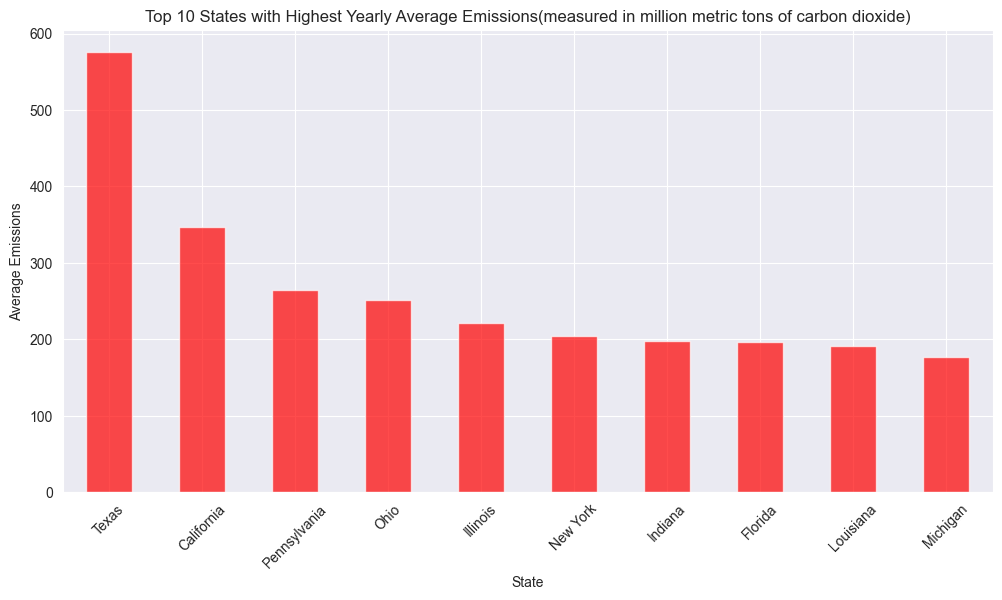

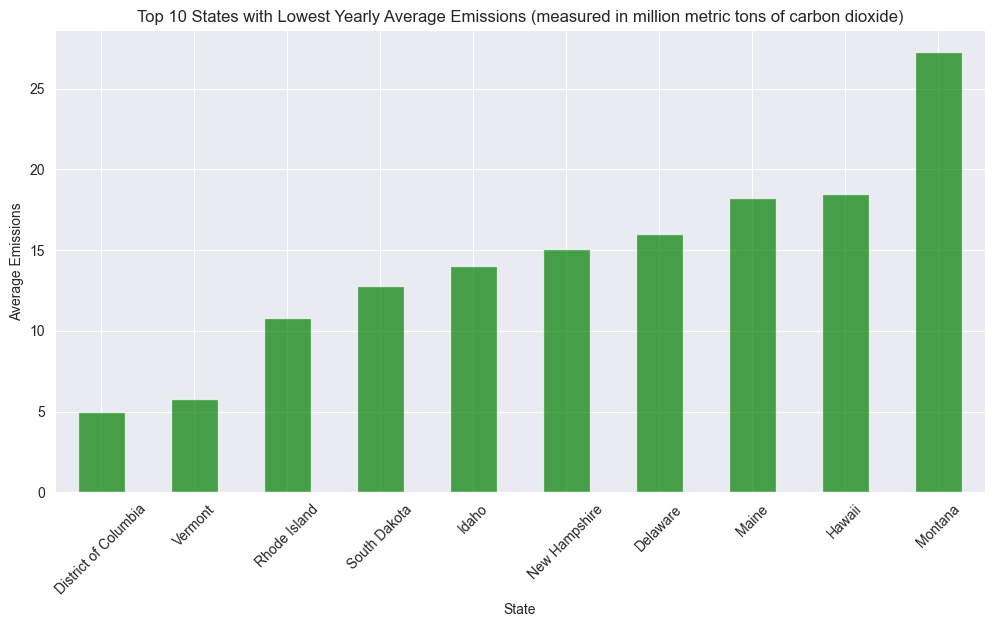

In [7]:
state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(10)
bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(10)

plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 10 States with Highest Yearly Average Emissions(measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
bottom_states.plot(kind='bar', color='green', alpha=0.7)
plt.title("Top 10 States with Lowest Yearly Average Emissions (measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

This code analyzes and visualizes emissions data alongside political scores for U.S. states. It first filters out rows containing "Total" in the state name and then identifies the top and bottom 10 states based on their average emissions over time. For each of these states, it detects local minima and maxima in emissions using the `argrelextrema` function. It then plots emissions data over time, marking the local extrema points with blue (minima) and red (maxima) markers, while displaying corresponding political scores at each point. The `plot_emissions_with_extrema` function is used to generate two separate plots: one for the top 10 states with the highest emissions and another for the bottom 10 states with the lowest emissions. Additionally, the `extract_state_name` function extracts the state name from a given directory path. This comprehensive analysis helps in understanding the trends in emissions in relation to political scores over time.

In [8]:
def extract_state_name(base_directory):
    return os.path.basename(base_directory)

In [9]:
def analyze_and_plot_emissions(state_emissions_data, political_scores_data):
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].isna()]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Source:", na=False)]

    year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
    top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(5).index
    bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(5).index

    top_states_data = state_emissions_data[state_emissions_data['State'].isin(top_states)].set_index('State')[year_columns].T
    bottom_states_data = state_emissions_data[state_emissions_data['State'].isin(bottom_states)].set_index('State')[year_columns].T

    def find_local_extrema(data):
        extrema = {}
        for state in data.columns:
            emissions = data[state].values
            years = data.index.values
            local_min_idx = argrelextrema(emissions, np.less)[0]  # Indices of local minima
            local_max_idx = argrelextrema(emissions, np.greater)[0]  # Indices of local maxima
            extrema[state] = {
                "min": [(years[i], emissions[i]) for i in local_min_idx],  # Store (year, emission) pairs for mins
                "max": [(years[i], emissions[i]) for i in local_max_idx]   # Store (year, emission) pairs for max
            }
        return extrema

    top_extrema = find_local_extrema(top_states_data)
    bottom_extrema = find_local_extrema(bottom_states_data)

    def plot_emissions_with_extrema(data, extrema, title, scores_data):
        plt.figure(figsize=(12, 6))

        for state in data.columns:
            plt.plot(data.index, data[state], label=state)

            for x, y in extrema[state]["min"]:
                plt.scatter(x, y, color='blue', marker='v', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Min label with party affiliation score
                    plt.text(x, y - 0.2, f"Min {score[0]:.2f}", fontsize=9, verticalalignment='bottom', horizontalalignment='center')
            for x, y in extrema[state]["max"]:
                plt.scatter(x, y, color='red', marker='^', zorder=5)
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    plt.text(x, y + 0.2, f"Max {score[0]:.2f}", fontsize=9, verticalalignment='top', horizontalalignment='center')

        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Emissions")
        plt.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_emissions_with_extrema(top_states_data, top_extrema, "Top 5 States with Highest Emissions Over Time", political_scores_data)
    plot_emissions_with_extrema(bottom_states_data, bottom_extrema, "Top 5 States with Lowest Emissions Over Time", political_scores_data)

In [10]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


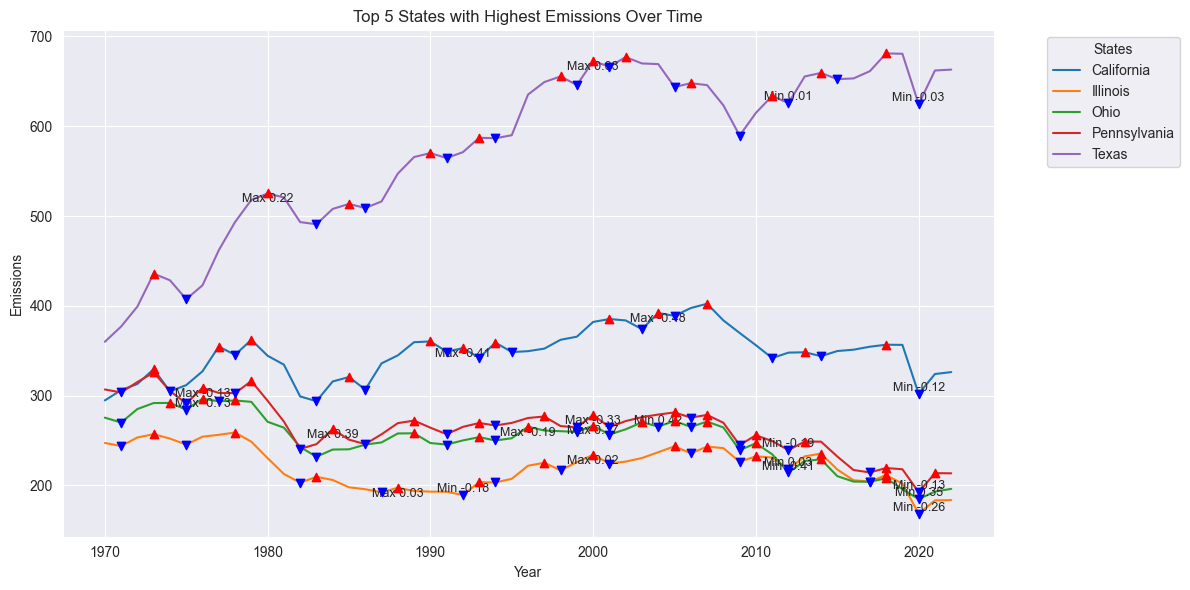

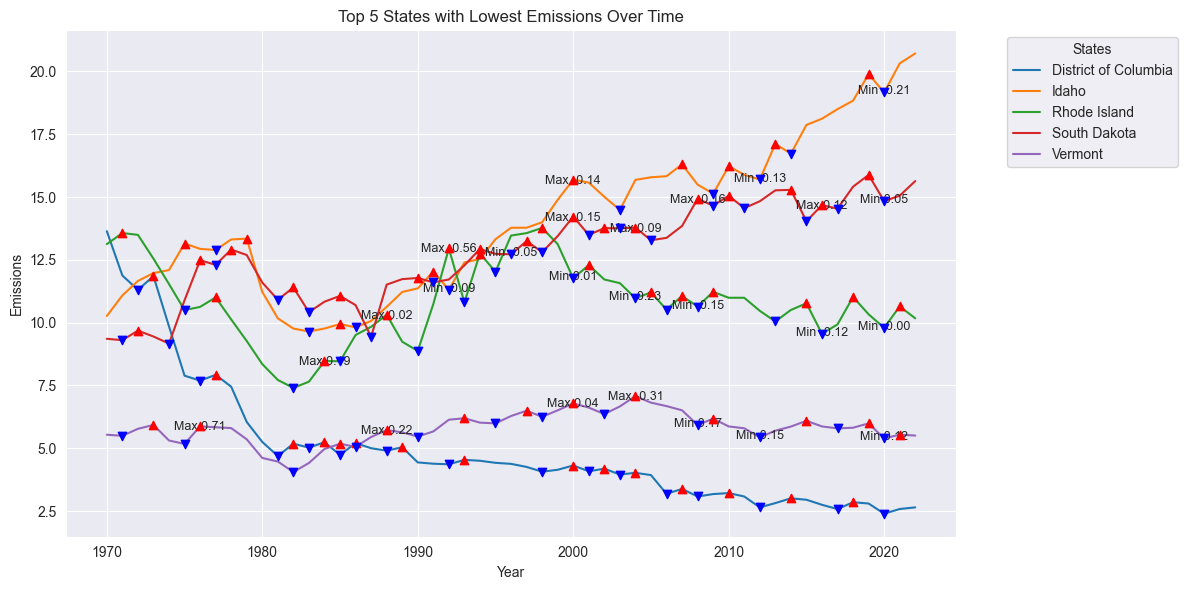

In [11]:
analyze_and_plot_emissions(state_emissions_data, final_political_scores_by_year)

### Demographic and Size Additions

This code performs data transformation and merging to create a comprehensive dataset for analysis. It starts by melting the `state_emissions_data` to reshape it, converting column names to lowercase and standardizing state names using a dictionary (`state_abbreviation_dict`). It then filters the data to include only valid years and merges it with `state_population_size_data` based on state and year. The `state_land_size_data` is also processed and merged to include land size information. Afterward, the political score data (`final_political_scores_by_year`) is integrated into the dataset by standardizing state names and performing another merge. The final result is a merged dataset (`final_merged_dataset`) containing emissions, population size, land size, and political scores for each state and year, ready for further analysis.

In [12]:
state_emissions_melted = state_emissions_data.melt(id_vars=["State"],
                                                   var_name="Year",
                                                   value_name="Emissions")
state_emissions_melted.columns = state_emissions_melted.columns.str.lower()
state_emissions_melted = state_emissions_melted.applymap(lambda x: x.lower() if isinstance(x, str) else x)

state_emissions_melted["state"] = state_emissions_melted["state"].map(state_abbreviation_dict)

state_emissions_melted["year"] = state_emissions_melted["year"].astype(str)
state_emissions_melted = state_emissions_melted.dropna(subset=["year"])  # Remove NaNs
state_emissions_melted = state_emissions_melted[state_emissions_melted["year"].str.isnumeric()]  # Keep only numeric years

state_emissions_melted["year"] = state_emissions_melted["year"].astype(int)
state_population_size_data["year"] = state_population_size_data["year"].astype(int)

merged_population_and_emission_data = state_emissions_melted.merge(state_population_size_data, on=["state", "year"], how="inner")

state_land_size_data = state_land_size_data.rename(columns={"State": "state"})
state_land_size_data["state"] = state_land_size_data["state"].str.lower().map(state_abbreviation_dict)

merged_size_population_emissions_data = merged_population_and_emission_data.merge(state_land_size_data, on="state", how="inner")
merged_size_population_emissions_data = merged_size_population_emissions_data.rename(columns={"Size (Square Miles)": "size"})

final_political_scores_by_year["state"] = final_political_scores_by_year["state"].str.lower().map(state_abbreviation_dict)

final_merged_dataset = merged_size_population_emissions_data.merge(final_political_scores_by_year, on=["state", "year"], how="inner")

final_merged_dataset

,state,year,emissions,population,size,party_affiliation_score
0,AL,1980,107.172609,3900368,52420,0.707140
1,AL,1984,95.389801,3951820,52420,0.365180
2,AL,1988,105.221571,4023844,52420,0.121370
3,AL,1992,120.975301,4139269,52420,0.225649
4,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...
578,WY,2004,64.383683,509106,97813,-0.206691
579,WY,2008,67.222540,546043,97813,-0.211750
580,WY,2012,66.647098,576656,97813,-0.260097
581,WY,2016,61.035090,585243,97813,-0.280461


### Bills Analysis

This code processes environmental bills and votes data across multiple directories to calculate a "Final Score" for each state and year. It begins by loading JSON files for bills and votes, normalizing and merging the data, and calculating the percentage of "yes" votes for each bill. The code identifies climate-related bills by checking for specific environmental terms in the bill description, calculates a weighted climate score based on vote percentages, and sums these scores to get the final score. The code is designed to process files for all states and years in a directory structure, aggregating the results into a final DataFrame. It also measures the execution time and saves the results to a CSV file. The final output provides a dataset of average "Final Scores" by year and state, reflecting the states' environmental legislative activity over time.

In [13]:
def process_bills_and_votes(bill_directory, vote_directory, environmental_terms):
    def load_json_files_from_directory(directory_path):
        data_list = []
        if os.path.exists(directory_path) and os.listdir(directory_path):
            for filename in os.listdir(directory_path):
                if filename.endswith(".json"):
                    with open(os.path.join(directory_path, filename), 'r') as file:
                        data = json.load(file)
                        df = pd.json_normalize(data)
                        data_list.append(df)
            return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()
        return pd.DataFrame()

    bill_df = load_json_files_from_directory(bill_directory)
    if bill_df.empty:
        return 0

    bill_df.columns = [col.split('.')[-1] for col in bill_df.columns]

    vote_df = load_json_files_from_directory(vote_directory)
    if vote_df.empty:
        return 0

    vote_df.columns = [col.split('.')[-1] for col in vote_df.columns]

    merged_df = pd.merge(bill_df, vote_df, on="bill_id", how="outer")
    merged_df = merged_df.drop_duplicates(subset='bill_id', keep='first')
    merged_df['percent_yes'] = merged_df['yea'] / merged_df['total']
    merged_df = merged_df[['percent_yes', 'bill_id', 'title', 'description']].reset_index().drop(columns=['index'])

    merged_df['climate'] = merged_df['description'].apply(lambda x: 1 if any(term.lower() in str(x).lower() for term in environmental_terms) else 0)
    merged_df.fillna(0)

    climate_ratio = merged_df['climate'].sum() / len(merged_df) if len(merged_df) > 0 else 0
    merged_df['weighted_climate'] = climate_ratio * merged_df['percent_yes']
    final_score = merged_df['weighted_climate'].sum()

    return final_score

def process_all_files(base_directory, environmental_terms):
    year = os.path.basename(base_directory).split('-')[0]
    file_dict = {}

    vote_dir = os.path.join(base_directory, 'vote')
    bill_dir = os.path.join(base_directory, 'bill')

    file_dict[year] = process_bills_and_votes(bill_dir, vote_dir, environmental_terms)

    df = pd.DataFrame(list(file_dict.items()), columns=['Year', 'Final_Score'])
    return df

def process_all_states(base_directory, environmental_terms):
    results = []
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)
        print(subdir_path)
        if os.path.isdir(subdir_path):
            subdirectory_df = process_all_files(subdir_path, environmental_terms)
            results.append(subdirectory_df)

    state = extract_state_name(base_directory)
    final_df = pd.concat(results, ignore_index=True)
    final_df['State'] = state
    return final_df

def process_all_directories(base_directory, environmental_terms):
    all_results = []
    state_count = 1

    for state_dir in os.listdir(base_directory):
        print(f"{state_count}: Processing state: {state_dir}")
        state_count+=1
        state_dir_path = os.path.join(base_directory, state_dir)

        if os.path.isdir(state_dir_path):
            state_df = process_all_states(state_dir_path, environmental_terms)
            all_results.append(state_df)

    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Year').reset_index().drop(columns=['index'])
    final_df = final_df.groupby(['Year', 'State'])['Final_Score'].mean().reset_index()

    return final_df

def process_all_directories_timed(base_directory, environmental_terms):
    start_time = time.time()

    results_df = process_all_directories(base_directory, environmental_terms)

    end_time = time.time()
    execution_time = end_time - start_time
    results_df.to_csv('data/results/election_scores.csv')
    print(f"Execution Time: {execution_time} seconds")

    return results_df

In [14]:
# DON'T RUN - TAKES HOURS TO TERMINATE
# results_df = process_all_directories_timed('data/bills', environmental_terms)
# results_df

This code processes the election scores data by reading a CSV file and cleaning the data by removing unnecessary columns and sorting by year and state. It then maps state abbreviations using a dictionary (`state_abbreviation_dict`). The data is grouped into four-year periods (starting from 2008), and the policy scores for each state are aggregated by summing the "Final_Score" within each year group. The resulting DataFrame is renamed to "Policy Scores" and contains aggregated scores by year group and state.

In [15]:
election_scores_df = pd.read_csv('../data/results/election_scores.csv')
election_scores_df = election_scores_df.drop(columns=['Unnamed: 0'])
election_scores_df = election_scores_df.sort_values(by=['Year', 'State'], ascending=True)
election_scores_df['State'] = election_scores_df['State'].map(state_abbreviation_dict)

start_year = 2008
election_scores_df['Year_Group'] = (election_scores_df['Year'] - start_year) // 4 * 4 + start_year
aggregated_scores_df = election_scores_df.groupby(['Year_Group', 'State'], as_index=False)['Final_Score'].sum()
aggregated_scores_df = aggregated_scores_df.rename(columns={'Final_Score': 'Policy Scores'})
aggregated_scores_df

,Year_Group,State,Policy Scores
0,2004,OH,0.000000
1,2004,PA,0.000000
2,2008,AK,0.000000
3,2008,AL,1.972585
4,2008,AR,23.282568
...,...,...,...
163,2024,TN,11.959624
164,2024,UT,1.664631
165,2024,VT,0.018692
166,2024,WA,14.846776


This code merges the `aggregated_scores_df` with `final_merged_dataset` based on matching year groups and states, using a right join to ensure all records from `final_merged_dataset` are included. It then drops the columns "State" and "Year_Group" and resets the index, cleaning up the final DataFrame. The resulting `final_df` contains the combined data with the aggregated policy scores and corresponding values from the merged dataset.

In [16]:
final_df = aggregated_scores_df.merge(final_merged_dataset,
                                       left_on=['Year_Group', 'State'],
                                       right_on=['year', 'state'],
                                       how='right')
final_df = final_df.drop(columns=['State', 'Year_Group']).reset_index().drop(columns='index')
final_df

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,NaN,AL,1980,107.172609,3900368,52420,0.707140
1,NaN,AL,1984,95.389801,3951820,52420,0.365180
2,NaN,AL,1988,105.221571,4023844,52420,0.121370
3,NaN,AL,1992,120.975301,4139269,52420,0.225649
4,NaN,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...,...
578,NaN,WY,2004,64.383683,509106,97813,-0.206691
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


This code identifies the numerical and categorical columns in the `final_df` DataFrame by selecting columns with `float64` and `int64` data types for numerical columns, and excluding them for categorical columns. It then applies a K-Nearest Neighbors (KNN) imputer to fill any missing values in the numerical columns, using 5 neighbors to estimate the missing data. The imputed values are applied to a copy of `final_df`, resulting in a new DataFrame (`final_df_imputed`) with the missing numerical data filled in.

In [17]:
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = final_df.select_dtypes(exclude=['float64', 'int64']).columns

imputer = SimpleImputer(strategy='mean')

final_df_imputed = final_df.copy()
final_df_imputed[numerical_columns] = imputer.fit_transform(final_df_imputed[numerical_columns])

final_df_dropped = final_df.dropna(axis=0)

In [18]:
final_df_imputed

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,24.412201,AL,1980.0,107.172609,3900368.0,52420.0,0.707140
1,24.412201,AL,1984.0,95.389801,3951820.0,52420.0,0.365180
2,24.412201,AL,1988.0,105.221571,4023844.0,52420.0,0.121370
3,24.412201,AL,1992.0,120.975301,4139269.0,52420.0,0.225649
4,24.412201,AL,1996.0,137.217372,4290403.0,52420.0,0.015759
...,...,...,...,...,...,...,...
578,24.412201,WY,2004.0,64.383683,509106.0,97813.0,-0.206691
579,3.146390,WY,2008.0,67.222540,546043.0,97813.0,-0.211750
580,14.832834,WY,2012.0,66.647098,576656.0,97813.0,-0.260097
581,12.360478,WY,2016.0,61.035090,585243.0,97813.0,-0.280461


In [19]:
final_df_dropped

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
7,1.972585,AL,2008,139.355377,4718206,52420,-0.108467
8,11.211519,AL,2012,122.438181,4816632,52420,0.056473
9,10.323113,AL,2016,113.418599,4866824,52420,-0.118678
10,5.094120,AL,2020,97.977476,5033094,52420,-0.215275
18,0.000000,AK,2008,39.079214,687455,665384,0.072105
...,...,...,...,...,...,...,...
570,4.397349,WI,2020,86.643133,5897375,65496,-0.268129
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


In [20]:
def fill_missing_years(df):
    df['year'] = df['year'].astype(int)
    max_year = min(df['year'].max(), 2024)
    full_years = pd.DataFrame({'year': range(df['year'].min(), max_year + 1)})
    states = df['state'].unique()
    filled_df = []

    for state in states:
        state_df = df[df['state'] == state]
        state_df = pd.merge(full_years, state_df, on='year', how='left')
        state_df['state'] = state
        for col in ['Policy Scores', 'emissions', 'population', 'size', 'party_affiliation_score']:
            state_df[col] = state_df[col].interpolate(method='linear', limit_direction='both')
        filled_df.append(state_df)

    return pd.concat(filled_df).reset_index(drop=True)

In [21]:
final_df_imputed = fill_missing_years(final_df_imputed)
final_df_imputed

,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,1976,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
1,1977,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
2,1978,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
3,1979,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
4,1980,24.412201,AL,107.172609,3900368.0,52420.0,0.707140
...,...,...,...,...,...,...,...
2245,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
2246,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
2247,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
2248,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


In [22]:
final_df_dropped = fill_missing_years(final_df_dropped)
final_df_dropped

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,2004,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
1,2005,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
2,2006,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
3,2007,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
4,2008,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
...,...,...,...,...,...,...,...
624,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
625,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
626,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
627,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


#### Prepare Full Data

This code creates a copy of the `final_df_imputed` DataFrame and applies standardization to the selected columns. It first identifies the columns to normalize by excluding "state," "year," and "emissions" from the list of columns. Then, it uses the `StandardScaler` from `sklearn.preprocessing` to normalize these columns, transforming them to have a mean of 0 and a standard deviation of 1. The transformed data is assigned back to the corresponding columns in the `final_df_imputed` DataFrame, resulting in the normalized dataset.

In [23]:
def normalize_data(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    scaler = StandardScaler()
    columns_to_normalize = [col for col in df.columns if col not in exclude_columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

final_df_imputed_normalized = normalize_data(final_df_imputed)
final_df_dropped_normalized = normalize_data(final_df_dropped)

In [24]:
state_emissions_melted = state_emissions_melted.dropna()
state_emissions_melted

,state,year,emissions
0,AL,1970,102.717308
1,AK,1970,11.358988
2,AZ,1970,24.937739
3,AR,1970,36.238491
4,CA,1970,294.672829
...,...,...,...
2854,VA,2022,96.233942
2855,WA,2022,74.701895
2856,WV,2022,79.179688
2857,WI,2022,90.591835


In [25]:
final_df_imputed_normalized = final_df_imputed_normalized.copy()
final_df_imputed_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_imputed_normalized['emissions'] = state_emissions_melted['emissions']

final_df_imputed_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)
final_df_imputed_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,1976,0.008907,108.123429,-0.260609,-0.244045,0.707140
1,AL,1977,0.008907,111.715385,-0.260609,-0.244045,0.707140
2,AL,1978,0.008907,106.665665,-0.260609,-0.244045,0.707140
3,AL,1979,0.008907,111.618240,-0.260609,-0.244045,0.707140
4,AL,1980,0.008907,107.172609,-0.260609,-0.244045,0.707140
...,...,...,...,...,...,...,...
2245,WY,2016,-0.696744,61.035090,-0.808000,0.227085,-0.280461
2246,WY,2017,-0.798765,62.583762,-0.808312,0.227085,-0.287553
2247,WY,2018,-0.900786,63.639323,-0.808624,0.227085,-0.294644
2248,WY,2019,-1.002807,58.897673,-0.808936,0.227085,-0.301735


In [26]:
final_df_dropped_normalized = final_df_dropped_normalized.copy()
final_df_dropped_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_dropped_normalized['emissions'] = state_emissions_melted['emissions']

final_df_dropped_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)

final_df_dropped_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,2004,-0.576684,141.975194,-0.227362,-0.297275,-0.108467
1,AL,2005,-0.576684,143.531689,-0.227362,-0.297275,-0.108467
2,AL,2006,-0.576684,145.768689,-0.227362,-0.297275,-0.108467
3,AL,2007,-0.576684,147.286933,-0.227362,-0.297275,-0.108467
4,AL,2008,-0.576684,139.355377,-0.227362,-0.297275,-0.108467
...,...,...,...,...,...,...,...
624,WY,2016,-0.279498,61.035090,-0.788170,0.120018,-0.280461
625,WY,2017,-0.329346,62.583762,-0.788426,0.120018,-0.287553
626,WY,2018,-0.379194,63.639323,-0.788683,0.120018,-0.294644
627,WY,2019,-0.429043,58.897673,-0.788939,0.120018,-0.301735


Emissions initially declined, then rose steadily until the early 2000s, after which they began a continuous downward trend.

    year   emissions
0   1976   93.737515
1   1977   96.500934
2   1978   97.334440
3   1979   98.717193
4   1980   95.144842
5   1981   92.723631
6   1982   87.861297
7   1983   87.467112
8   1984   91.930208
9   1985   91.999663
10  1986   92.058266
11  1987   95.078238
12  1988   99.671862
13  1989  101.144680
14  1990  100.327565
15  1991   99.386259
16  1992  101.288180
17  1993  103.182156
18  1994  104.600861
19  1995  105.889315
20  1996  109.851460
21  1997  111.294663
22  1998  111.974872
23  1999  113.261021
24  2000  117.117254
25  2001  114.923910
26  2002  115.624927
27  2003  117.050857
28  2004  119.010031
29  2005  119.520495
30  2006  117.968544
31  2007  119.772586
32  2008  115.888839
33  2009  107.629638
34  2010  111.463404
35  2011  108.664135
36  2012  104.260472
37  2013  106.744099
38  2014  107.855380
39  2015  104.798473
40  2016  102.938219
41  2017  102.237081
42  2018  105.286101
43  2019  102.639411
44  2020   91.391576


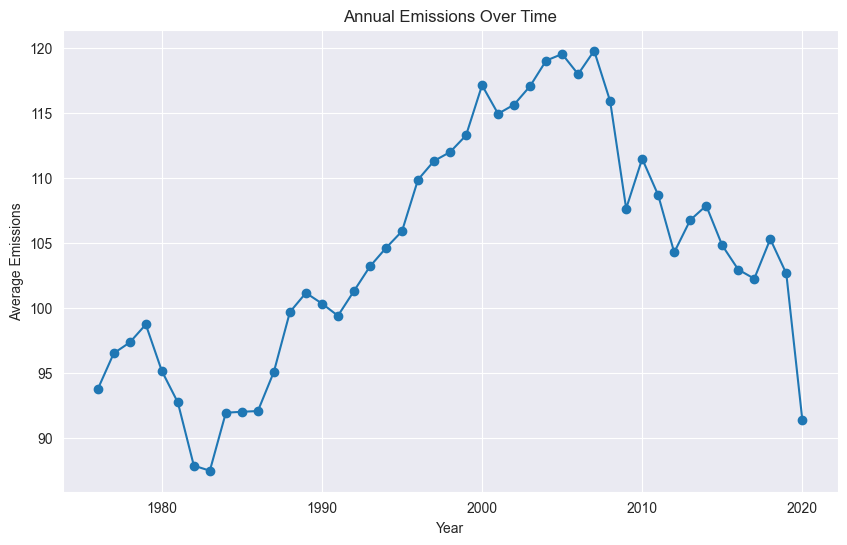

In [27]:
emissions_by_year = final_df_imputed_normalized.groupby('year')['emissions'].mean().reset_index()
print(emissions_by_year)
plt.figure(figsize=(10, 6))
plt.plot(emissions_by_year['year'], emissions_by_year['emissions'], marker='o')
plt.title('Annual Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('Average Emissions')
plt.grid(True)
plt.show()

Average absolute change in national emissions year-over-year: 2.4745
Average total emissions per year: 104.3380
Change as percentage of average total emissions: 2.37%


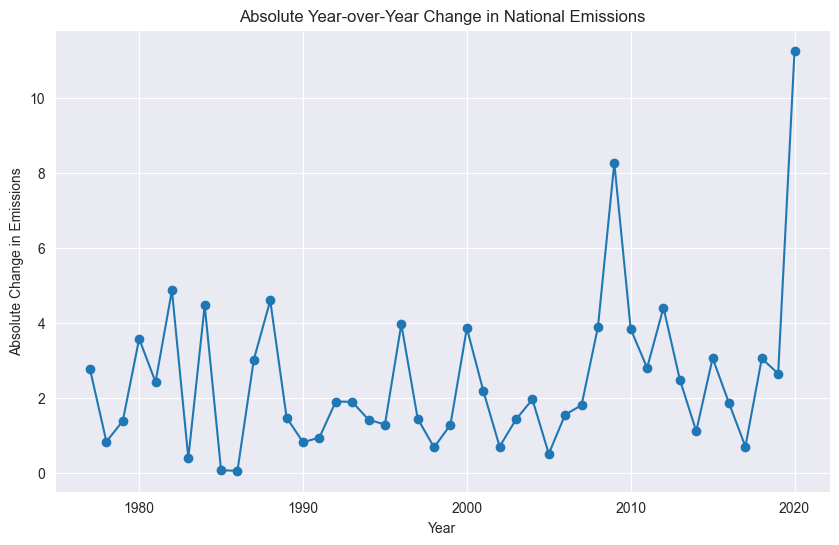

In [28]:
overall_yearly_mean = final_df_imputed_normalized.groupby('year')['emissions'].mean().rename('overall_mean')

overall_yearly_mean = overall_yearly_mean.sort_index()
yearly_changes = overall_yearly_mean.diff().dropna()
average_yearly_change = yearly_changes.abs().mean()
average_total_emissions = overall_yearly_mean.mean()
change_percentage = (average_yearly_change / average_total_emissions) * 100

print(f"Average absolute change in national emissions year-over-year: {average_yearly_change:.4f}")
print(f"Average total emissions per year: {average_total_emissions:.4f}")
print(f"Change as percentage of average total emissions: {change_percentage:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(yearly_changes.index, yearly_changes.abs(), marker='o')
plt.title('Absolute Year-over-Year Change in National Emissions')
plt.xlabel('Year')
plt.ylabel('Absolute Change in Emissions')
plt.grid(True)
plt.show()


#### Final Results

In [29]:
# Final dataframes are:
#   1. final_df_dropped_normalized
#   2. final_df_dropped
#   3. final_df_imputed_normalized
#   4. final_df_imputed

In [30]:
final_df = final_df_imputed.drop(columns=['Policy Scores'])
final_df_normalized = final_df_imputed_normalized.drop(columns=['Policy Scores'])

In [31]:
df_modified_normalized = final_df_normalized.copy()
df_modified_normalized['emissions_per_capita'] = df_modified_normalized['emissions'] / df_modified_normalized['population']
df_modified_normalized['population_density'] = df_modified_normalized['population'] / df_modified_normalized['size']
df_modified_normalized = df_modified_normalized.drop(columns=['population', 'size', 'emissions'])

df_modified = final_df.copy()
df_modified['emissions_per_capita'] = df_modified['emissions'] / df_modified['population']
df_modified['population_density'] = df_modified['population'] / df_modified['size']
df_modified = df_modified.drop(columns=['population', 'size', 'emissions'])

## Final Analysis

### Linear Models

#### Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_linear_regression_forecasting(df, window_size=3, n_splits=5, use_ridge=False, ridge_alpha=1.0):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'emissions' not in df.columns:
            print("Required columns ('state', 'emissions') are missing.")
            return

        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + \
                   ['population', 'size', 'party_affiliation_score']
        X = df[features]
        y = df['emissions']
        states = df['state']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores, mse_scores, explained_scores = [], [], []
        coefs_all_folds = []
        top_feature_counts = []
        all_r2_by_state = []

        plt.figure(figsize=(10, 6))

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            states_test = states.iloc[test_index]

            model = Ridge(alpha=ridge_alpha, normalize=True) if use_ridge else LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            explained_var = explained_variance_score(y_test, y_pred)

            print(f"Fold {fold} — R²: {r2:.4f}, MSE: {mse:.4f}, Explained Variance: {explained_var:.4f}")
            r2_scores.append(r2)
            mse_scores.append(mse)
            explained_scores.append(explained_var)
            coefs_all_folds.append(model.coef_)

            plt.scatter(y_test, y_pred, label=f'Fold {fold}', alpha=0.6)

            fold_df = df.iloc[test_index].copy()
            fold_df['predicted'] = y_pred
            fold_r2 = fold_df.groupby('state').apply(lambda g: r2_score(g['emissions'], g['predicted']))
            all_r2_by_state.append(fold_r2)

            for state, group in fold_df.groupby('state'):
                if len(group) < window_size + 3:
                    continue
                X_state = group[features]
                y_state = group['emissions']
                model_state = Ridge(alpha=ridge_alpha, normalize=True) if use_ridge else LinearRegression()
                model_state.fit(X_state, y_state)
                coefs = pd.Series(model_state.coef_, index=features).abs()
                top_feature = coefs.idxmax()
                top_feature_counts.append(top_feature)

        min_val, max_val = y.min(), y.max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
        plt.xlabel('Actual Emissions')
        plt.ylabel('Predicted Emissions')
        plt.title('Ridge Regression' if use_ridge else 'Linear Regression')
        plt.legend(title='Fold')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nAverage R² Score: {np.mean(r2_scores):.4f}")
        print(f"Average Mean Squared Error: {np.mean(mse_scores):.4f}")
        print(f"Average Explained Variance Score: {np.mean(explained_scores):.4f}")

        coef_matrix = np.array(coefs_all_folds)
        mean_coefs = coef_matrix.mean(axis=0)
        std_coefs = coef_matrix.std(axis=0)
        coef_df = pd.DataFrame({
            'Feature': features,
            'Mean Coefficient': mean_coefs,
            'Std Deviation': std_coefs
        }).sort_values(by='Mean Coefficient', key=abs, ascending=False)

        print("\nAverage Feature Coefficients Across All Folds:")
        print(coef_df)

        # Combine all fold-wise R² per state into a single average R² per state
        r2_by_state_all_folds = pd.concat(all_r2_by_state, axis=1).mean(axis=1)
        stratified_r2 = r2_by_state_all_folds.mean()

        print(f"\nStratified R² (average across states): {stratified_r2:.4f}")
        print(f"Highest R² State: {r2_by_state_all_folds.idxmax()} ({r2_by_state_all_folds.max():.4f})")
        print(f"Lowest R² State: {r2_by_state_all_folds.idxmin()} ({r2_by_state_all_folds.min():.4f})")

        plt.figure(figsize=(12, 6))
        r2_by_state_all_folds.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0, color='red', linestyle='--')
        plt.title('R² by State (Averaged Across Folds)')
        plt.xlabel('State')
        plt.ylabel('R² Score')
        plt.tight_layout()
        plt.show()

        percent_party_top = (sum(f == 'party_affiliation_score' for f in top_feature_counts) / len(top_feature_counts)) * 100
        print(f"\nPercentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: {percent_party_top:.2f}%")

        return (
            r2_scores,
            mse_scores,
            explained_scores,
            coef_df,
            stratified_r2,
            r2_by_state_all_folds.sort_values(ascending=False),
            percent_party_top
        )

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


Shape after sliding window processing: (1750, 16)
Fold 1 — R²: 0.9934, MSE: 42.5161, Explained Variance: 0.9936
Fold 2 — R²: 0.9934, MSE: 21.5961, Explained Variance: 0.9934
Fold 3 — R²: 0.9939, MSE: 13.9497, Explained Variance: 0.9939
Fold 4 — R²: 0.9966, MSE: 29.1216, Explained Variance: 0.9966
Fold 5 — R²: 0.9983, MSE: 56.8265, Explained Variance: 0.9983


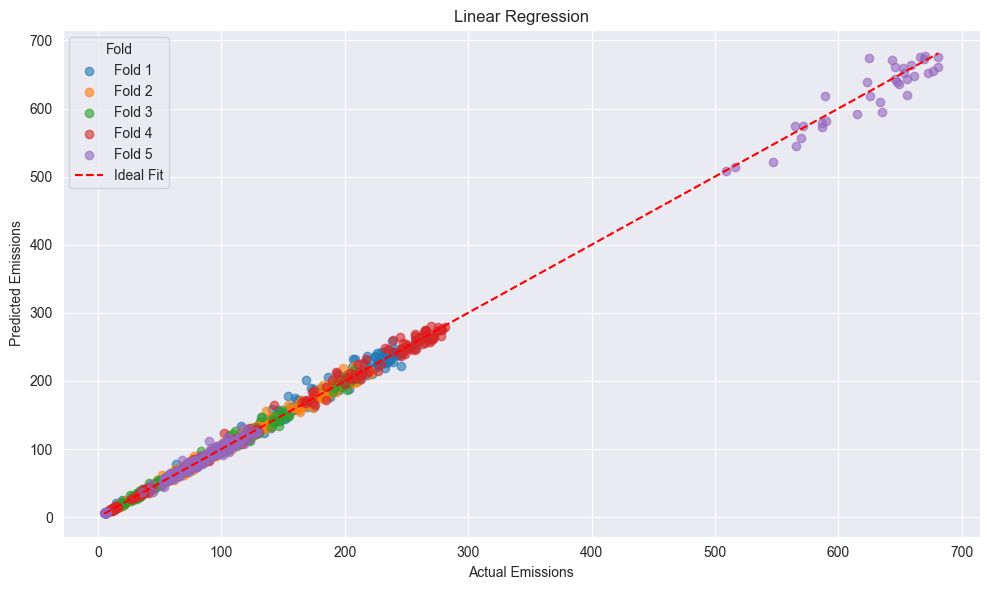


Average R² Score: 0.9951
Average Mean Squared Error: 32.8020
Average Explained Variance Score: 0.9952

Average Feature Coefficients Across All Folds:
                    Feature  Mean Coefficient  Std Deviation
9       emissions_t_minus_1          1.001853       0.029114
12  party_affiliation_score          0.785410       0.475725
10               population         -0.255849       0.345682
7       emissions_t_minus_3          0.238430       0.100649
2       emissions_t_minus_8          0.197455       0.019478
1       emissions_t_minus_9         -0.144485       0.028565
5       emissions_t_minus_5         -0.126442       0.020895
6       emissions_t_minus_4         -0.090131       0.031137
4       emissions_t_minus_6         -0.048104       0.075443
8       emissions_t_minus_2         -0.035370       0.039900
11                     size          0.023135       0.035263
0      emissions_t_minus_10          0.019047       0.005008
3       emissions_t_minus_7         -0.012426       0.04

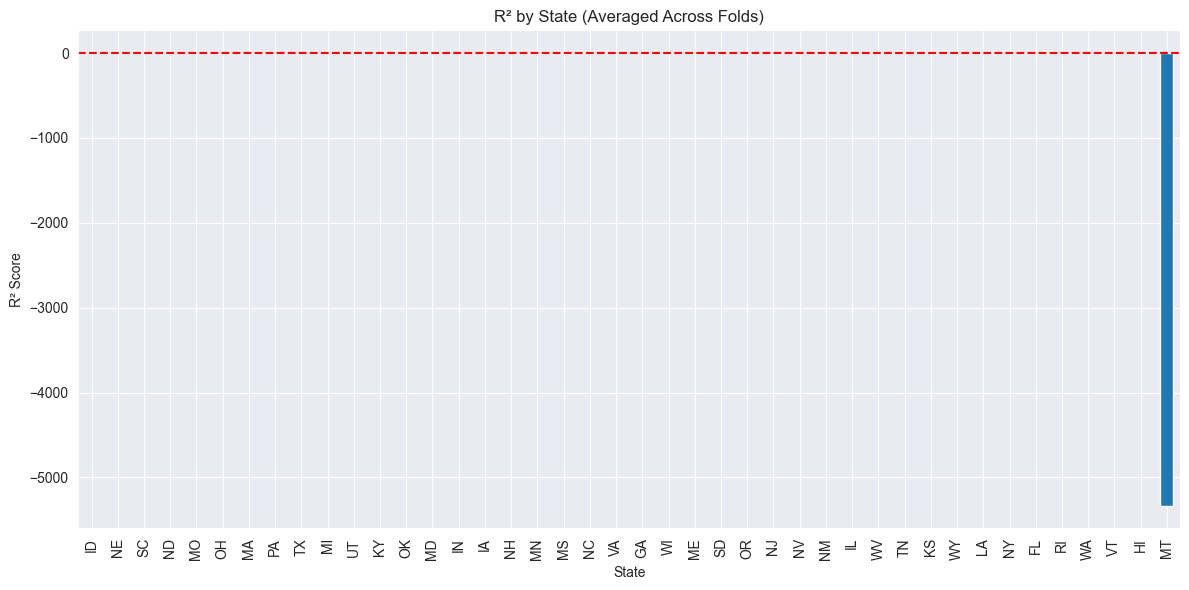


Percentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: 20.93%


In [33]:
r2_scores, mse_scores, explained_scores, coef_df, stratified_r2, r2_by_state, percent_party_top = train_linear_regression_forecasting(final_df_normalized, window_size=10)

Shape after sliding window processing: (1750, 16)
Fold 1 — R²: 0.9717, MSE: 182.6986, Explained Variance: 0.9717
Fold 2 — R²: 0.9693, MSE: 99.9334, Explained Variance: 0.9713
Fold 3 — R²: 0.9784, MSE: 49.6036, Explained Variance: 0.9814
Fold 4 — R²: 0.9864, MSE: 115.1884, Explained Variance: 0.9867
Fold 5 — R²: 0.9813, MSE: 621.0670, Explained Variance: 0.9826


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in 

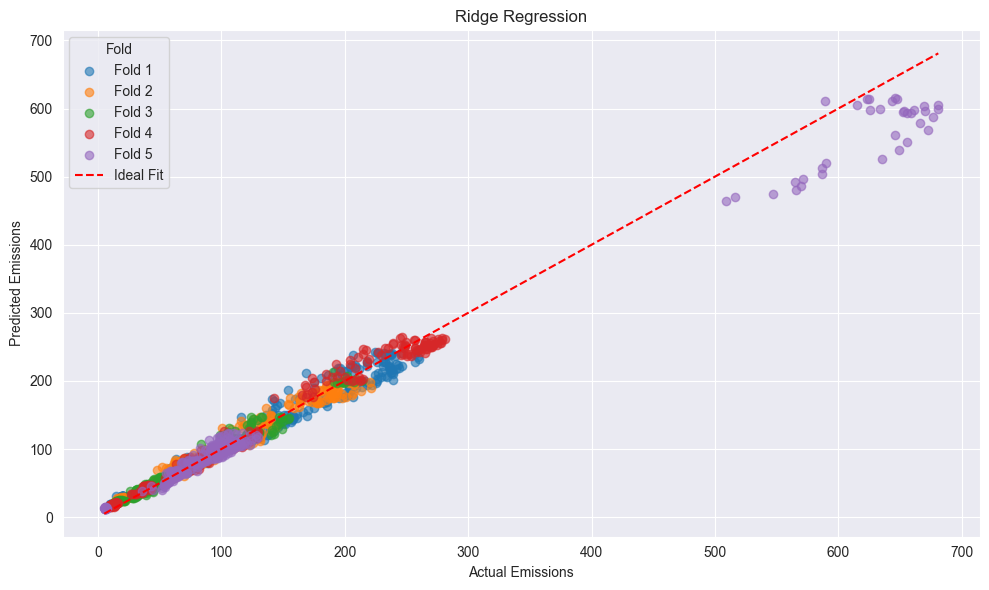


Average R² Score: 0.9774
Average Mean Squared Error: 213.6982
Average Explained Variance Score: 0.9787

Average Feature Coefficients Across All Folds:
                    Feature  Mean Coefficient  Std Deviation
10               population          4.200870       0.137047
12  party_affiliation_score          3.374644       1.091231
9       emissions_t_minus_1          0.110868       0.003448
8       emissions_t_minus_2          0.104998       0.002482
7       emissions_t_minus_3          0.101054       0.002189
6       emissions_t_minus_4          0.095745       0.001394
5       emissions_t_minus_5          0.089897       0.000636
4       emissions_t_minus_6          0.085033       0.000335
3       emissions_t_minus_7          0.081442       0.000548
2       emissions_t_minus_8          0.078945       0.001193
1       emissions_t_minus_9          0.075822       0.002162
0      emissions_t_minus_10          0.074754       0.002629
11                     size         -0.006344       0.1

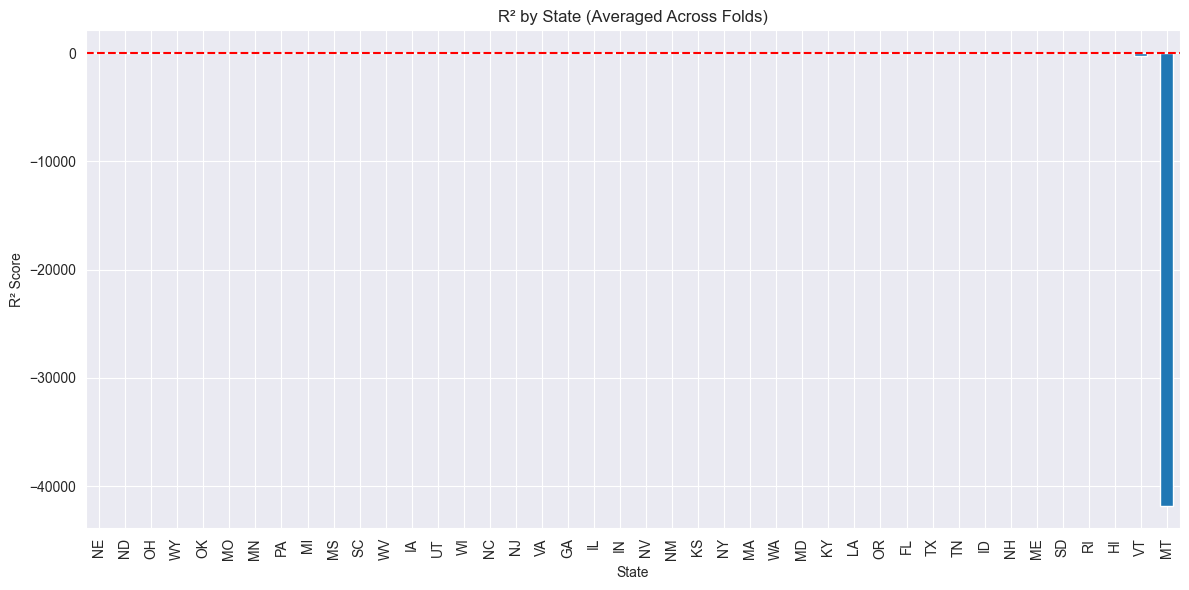


Percentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: 34.88%


([0.971675094948314,
  0.9693000285502801,
  0.9783992020734651,
  0.9864142702858948,
  0.9813017998798124],
 [182.69861143515107,
  99.9334239891131,
  49.60357410943259,
  115.18843230701918,
  621.0669948325572],
 [0.9716859817243275,
  0.9713265731215364,
  0.9814417146431554,
  0.9866651109628914,
  0.9825756904233003],
                     Feature  Mean Coefficient  Std Deviation
 10               population          4.200870       0.137047
 12  party_affiliation_score          3.374644       1.091231
 9       emissions_t_minus_1          0.110868       0.003448
 8       emissions_t_minus_2          0.104998       0.002482
 7       emissions_t_minus_3          0.101054       0.002189
 6       emissions_t_minus_4          0.095745       0.001394
 5       emissions_t_minus_5          0.089897       0.000636
 4       emissions_t_minus_6          0.085033       0.000335
 3       emissions_t_minus_7          0.081442       0.000548
 2       emissions_t_minus_8          0.078945      

In [34]:
from sklearn.linear_model import LinearRegression, Ridge

train_linear_regression_forecasting(final_df_normalized, window_size=10, n_splits=5, use_ridge=True, ridge_alpha=0.5)

In [35]:
final_df_normalized_copy = final_df_normalized

final_df_normalized_copy['emissions_change'] = (
    final_df_normalized_copy
    .sort_values(['state', 'year'])
    .groupby('state')['emissions']
    .diff()
)

state_means = final_df_normalized_copy.drop(columns=['year']).groupby('state').mean().reset_index()
r2_df = r2_by_state.reset_index()
r2_df.columns = ['state', 'r2_score']
merged_df = state_means.merge(r2_df, on='state', how='inner')
merged_df

,state,emissions,population,size,party_affiliation_score,emissions_change,r2_score
0,FL,205.585771,1.619112,-0.105611,0.022989,1.639718,0.349279
1,GA,143.813813,0.395467,-0.171341,0.190493,0.445915,0.791724
2,HI,18.977223,-0.706119,-0.674646,0.239968,-0.019457,-0.025047
3,IA,70.090911,-0.418500,-0.204055,-0.046225,0.113734,0.817933
4,ID,14.071070,-0.692804,0.079248,-0.147593,0.141576,0.930095
5,IL,218.660046,1.098035,-0.187023,-0.162847,-1.948971,0.711916
6,IN,201.913985,0.085540,-0.410108,0.021188,-0.632080,0.818126
7,KS,68.983121,-0.468256,0.065848,-0.269386,-0.071497,0.602871
8,KY,128.705130,-0.242718,-0.368717,0.220617,-0.006102,0.824106
9,LA,196.222858,-0.173526,-0.244481,0.300421,-0.019165,0.499028


#### Clustering

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def analyze_r2_clusters_from_merged(merged_df, max_k=10):
    try:
        clustering_features = ['r2_score', 'party_affiliation_score', 'emissions_change', 'population', 'size', 'emissions']

        for col in clustering_features:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

        merged_df[clustering_features] = merged_df[clustering_features].fillna(
            merged_df[clustering_features].mean()
        )

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(merged_df[clustering_features])

        sse = []
        K_range = range(1, min(len(X_scaled), max_k) + 1)
        for k in K_range:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit(X_scaled)
            sse.append(km.inertia_)

        kn = KneeLocator(K_range, sse, curve='convex', direction='decreasing')
        optimal_k = kn.elbow if kn.elbow is not None else 3  # fallback if not found

        plt.figure(figsize=(6, 4))
        plt.plot(K_range, sse, marker='o')
        if kn.elbow:
            plt.axvline(x=kn.elbow, color='red', linestyle='--', label=f'Elbow at k={kn.elbow}')
            plt.legend()
        plt.title('Elbow Method to Determine Optimal Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('SSE (Inertia)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"✅ Optimal number of clusters selected: {optimal_k}")

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        merged_df['cluster'] = kmeans.fit_predict(X_scaled)

        cluster_summary = merged_df.groupby('cluster')[clustering_features].mean().round(3)
        feature_ranges = cluster_summary.max() - cluster_summary.min()
        top_discriminative_features = feature_ranges.sort_values(ascending=False)

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=merged_df,
            x='party_affiliation_score',
            y='r2_score',
            hue='cluster',
            palette='viridis',
            s=100
        )
        plt.axhline(0, color='red', linestyle='--')
        plt.title('State R² vs. Party Affiliation Score (Clustered)')
        plt.xlabel('Party Affiliation Score')
        plt.ylabel('R² Score')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print("\nCluster Summary:")
        print(cluster_summary)

        print("\nTop Discriminative Features Across Clusters:")
        print(top_discriminative_features)

        return merged_df, cluster_summary, top_discriminative_features

    except Exception as e:
        print(f"\n❌ An error occurred in clustering: {e}")
        return None


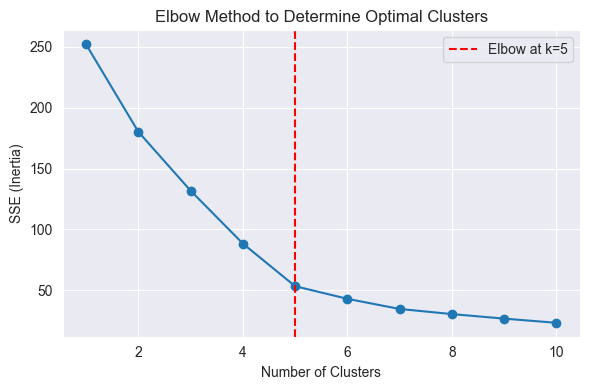

✅ Optimal number of clusters selected: 5


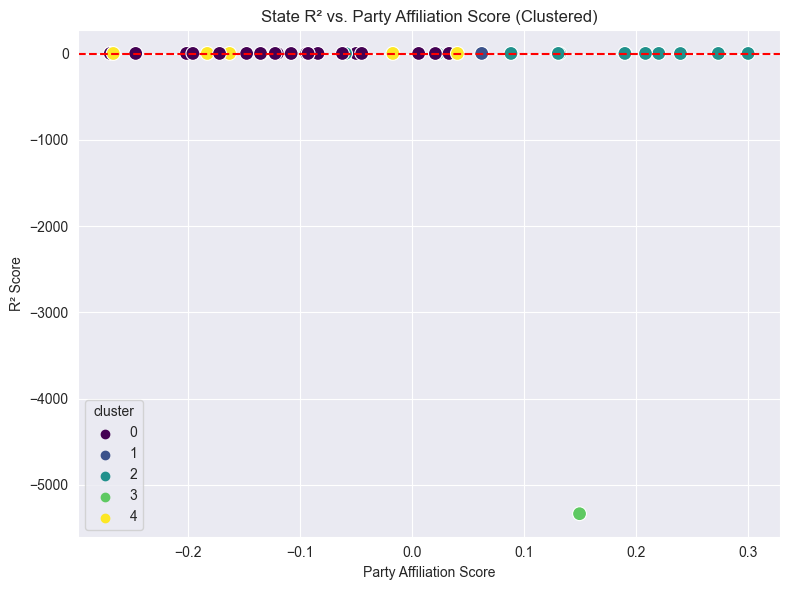


Cluster Summary:
         r2_score  party_affiliation_score  emissions_change  population  \
cluster                                                                    
0           0.716                   -0.109             0.174      -0.472   
1           0.835                    0.062             4.583       2.495   
2           0.669                    0.151            -0.087       0.086   
3       -5333.537                    0.150             0.151      -0.756   
4           0.732                   -0.118            -2.232       1.206   

          size  emissions  
cluster                    
0       -0.121     50.329  
1        2.000    595.267  
2       -0.384    124.012  
3        0.738     28.701  
4       -0.165    220.427  

Top Discriminative Features Across Clusters:
r2_score                   5334.372
emissions                   566.566
emissions_change              6.815
population                    3.251
size                          2.384
party_affiliation_score    

In [37]:
clustered_df, summary_df, top_features = analyze_r2_clusters_from_merged(merged_df)


#### Logistic Regression

In [38]:
final_df_normalized_tmp = final_df_normalized
final_df_normalized_tmp['political_party'] = final_df_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_normalized_tmp

,state,year,emissions,population,size,party_affiliation_score,emissions_change,political_party
0,AL,1976,108.123429,-0.260609,-0.244045,0.707140,NaN,D
1,AL,1977,111.715385,-0.260609,-0.244045,0.707140,3.591955,D
2,AL,1978,106.665665,-0.260609,-0.244045,0.707140,-5.049720,D
3,AL,1979,111.618240,-0.260609,-0.244045,0.707140,4.952575,D
4,AL,1980,107.172609,-0.260609,-0.244045,0.707140,-4.445631,D
...,...,...,...,...,...,...,...,...
2245,WY,2016,61.035090,-0.808000,0.227085,-0.280461,-2.884226,R
2246,WY,2017,62.583762,-0.808312,0.227085,-0.287553,1.548672,R
2247,WY,2018,63.639323,-0.808624,0.227085,-0.294644,1.055560,R
2248,WY,2019,58.897673,-0.808936,0.227085,-0.301735,-4.741650,R


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_logistic_regression_forecasting(
    df,
    window_size=3,
    n_splits=5,
    penalty='l2',
    C=1.0,
    exclude_demo_features=False
):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'political_party' not in df.columns:
            print("Required columns ('state', 'political_party') are missing.")
            return

        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        base_features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)]
        extra_features = [] if exclude_demo_features else ['population', 'size']
        features = base_features + extra_features

        X = df[features]
        y = df['political_party']
        states = df['state']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        accuracy_scores = []
        coefs_all_folds = []
        top_feature_counts = []

        plt.figure(figsize=(10, 6))

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            states_test = states.iloc[test_index]

            if len(np.unique(y_train)) < 2:
                print(f"Fold {fold} skipped — only one class ({np.unique(y_train)[0]}) present in training data.")
                continue

            model = LogisticRegression(penalty=penalty, C=C, max_iter=1000)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            accuracy_scores.append(acc)
            coefs_all_folds.append(model.coef_[0])

            print(f"Fold {fold} — Accuracy: {acc:.4f}")
            plt.scatter(range(len(y_test)), y_pred, alpha=0.6, label=f'Fold {fold}')

            fold_df = df.iloc[test_index].copy()
            for state, group in fold_df.groupby('state'):
                if len(group) < window_size + 3:
                    continue
                X_state = group[features]
                y_state = group['political_party']
                if len(np.unique(y_state)) < 2:
                    continue
                model_state = LogisticRegression(penalty=penalty, C=C, max_iter=1000)
                model_state.fit(X_state, y_state)
                coefs = pd.Series(model_state.coef_[0], index=features).abs()
                top_feature = coefs.idxmax()
                top_feature_counts.append(top_feature)

            if fold == n_splits:
                final_test_df = pd.DataFrame({
                    'state': states_test.values,
                    'actual': y_test.values,
                    'predicted': y_pred
                })

        plt.xlabel('Sample Index')
        plt.ylabel('Predicted Political Party')
        plt.title('Logistic Regression Predictions by Fold')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if not accuracy_scores:
            print("\nNo valid folds with both classes. Cannot compute overall metrics.")
            return None

        print(f"\nAverage Accuracy Across Folds: {np.mean(accuracy_scores):.4f}")

        coef_matrix = np.array(coefs_all_folds)
        mean_coefs = coef_matrix.mean(axis=0)
        std_coefs = coef_matrix.std(axis=0)

        coef_df = pd.DataFrame({
            'Feature': features,
            'Mean Coefficient': mean_coefs,
            'Std Deviation': std_coefs
        }).sort_values(by='Mean Coefficient', key=abs, ascending=False)

        print("\nAverage Feature Coefficients Across All Folds:")
        print(coef_df)

        # Non-lag feature summary
        non_lag_df = coef_df[~coef_df['Feature'].str.startswith('emissions_t_minus_')]
        print("\nNon-Lag Feature Coefficients (Excludes emissions_t_minus_X):")
        print(non_lag_df)

        accuracy_by_state = final_test_df.groupby('state').apply(lambda g: accuracy_score(g['actual'], g['predicted']))
        stratified_accuracy = accuracy_by_state.mean()

        print(f"\nStratified Accuracy (average across states): {stratified_accuracy:.4f}")
        print(f"Highest Accuracy State: {accuracy_by_state.idxmax()} ({accuracy_by_state.max():.4f})")
        print(f"Lowest Accuracy State: {accuracy_by_state.idxmin()} ({accuracy_by_state.min():.4f})")

        plt.figure(figsize=(12, 6))
        accuracy_by_state.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0.5, color='red', linestyle='--')
        plt.title('Accuracy by State (Last Fold)')
        plt.xlabel('State')
        plt.ylabel('Accuracy')
        plt.tight_layout()
        plt.show()

        total_state_models = len(top_feature_counts)
        top_feature_counts_series = pd.Series(top_feature_counts)
        top_feature_counts_percent = top_feature_counts_series.value_counts(normalize=True) * 100

        print("\nTop Feature Frequency (Percent of States Where Each Feature Was Most Predictive):")
        print(top_feature_counts_percent)

        return (
            accuracy_scores,
            coef_df,
            non_lag_df,
            stratified_accuracy,
            accuracy_by_state.sort_values(ascending=False),
            top_feature_counts_percent
        )

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

Shape after sliding window processing: (2100, 11)
Fold 1 — Accuracy: 0.5857
Fold 2 — Accuracy: 0.5600
Fold 3 — Accuracy: 0.5800
Fold 4 — Accuracy: 0.5629
Fold 5 — Accuracy: 0.6886


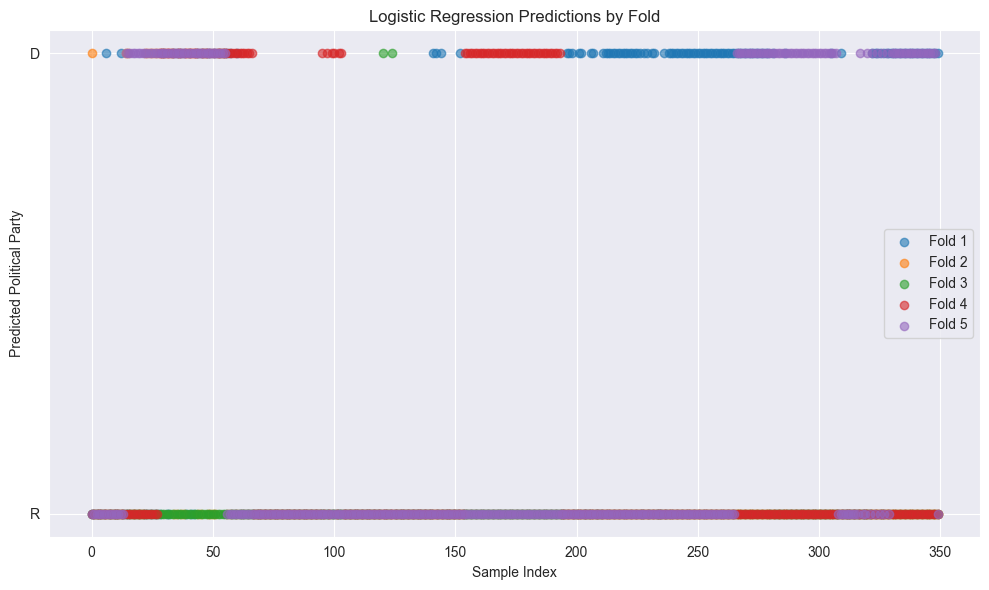


Average Accuracy Across Folds: 0.5954

Average Feature Coefficients Across All Folds:
               Feature  Mean Coefficient  Std Deviation
3           population          0.768838       0.246082
4                 size          0.086666       0.037699
2  emissions_t_minus_1         -0.017399       0.011797
1  emissions_t_minus_2          0.007755       0.003583
0  emissions_t_minus_3          0.000645       0.008040

Non-Lag Feature Coefficients (Excludes emissions_t_minus_X):
      Feature  Mean Coefficient  Std Deviation
3  population          0.768838       0.246082
4        size          0.086666       0.037699

Stratified Accuracy (average across states): 0.6376
Highest Accuracy State: UT (1.0000)
Lowest Accuracy State: TN (0.0000)


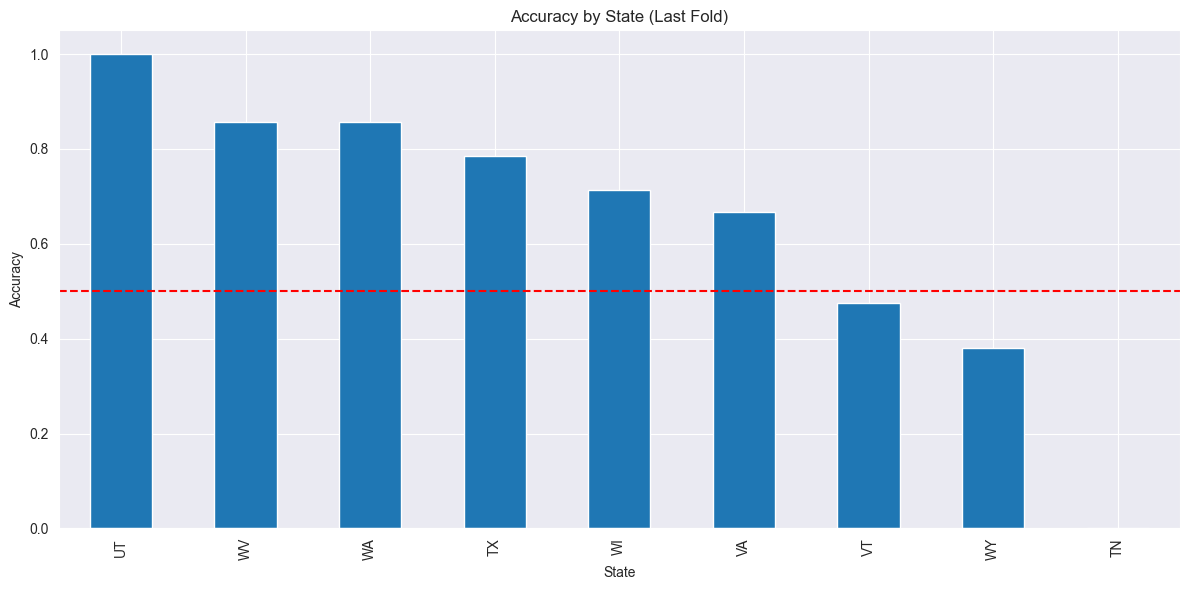


Top Feature Frequency (Percent of States Where Each Feature Was Most Predictive):
population             36.111111
emissions_t_minus_3    33.333333
emissions_t_minus_1    19.444444
emissions_t_minus_2    11.111111
dtype: float64


([0.5857142857142857, 0.56, 0.58, 0.5628571428571428, 0.6885714285714286],
                Feature  Mean Coefficient  Std Deviation
 3           population          0.768838       0.246082
 4                 size          0.086666       0.037699
 2  emissions_t_minus_1         -0.017399       0.011797
 1  emissions_t_minus_2          0.007755       0.003583
 0  emissions_t_minus_3          0.000645       0.008040,
       Feature  Mean Coefficient  Std Deviation
 3  population          0.768838       0.246082
 4        size          0.086666       0.037699,
 0.6375661375661374,
 state
 UT    1.000000
 WV    0.857143
 WA    0.857143
 TX    0.785714
 WI    0.714286
 VA    0.666667
 VT    0.476190
 WY    0.380952
 TN    0.000000
 dtype: float64,
 population             36.111111
 emissions_t_minus_3    33.333333
 emissions_t_minus_1    19.444444
 emissions_t_minus_2    11.111111
 dtype: float64)

In [40]:
train_logistic_regression_forecasting(final_df_normalized_tmp)

Shape after sliding window processing: (2100, 11)
Fold 1 — Accuracy: 0.5800
Fold 2 — Accuracy: 0.4829
Fold 3 — Accuracy: 0.5857
Fold 4 — Accuracy: 0.5657
Fold 5 — Accuracy: 0.6343


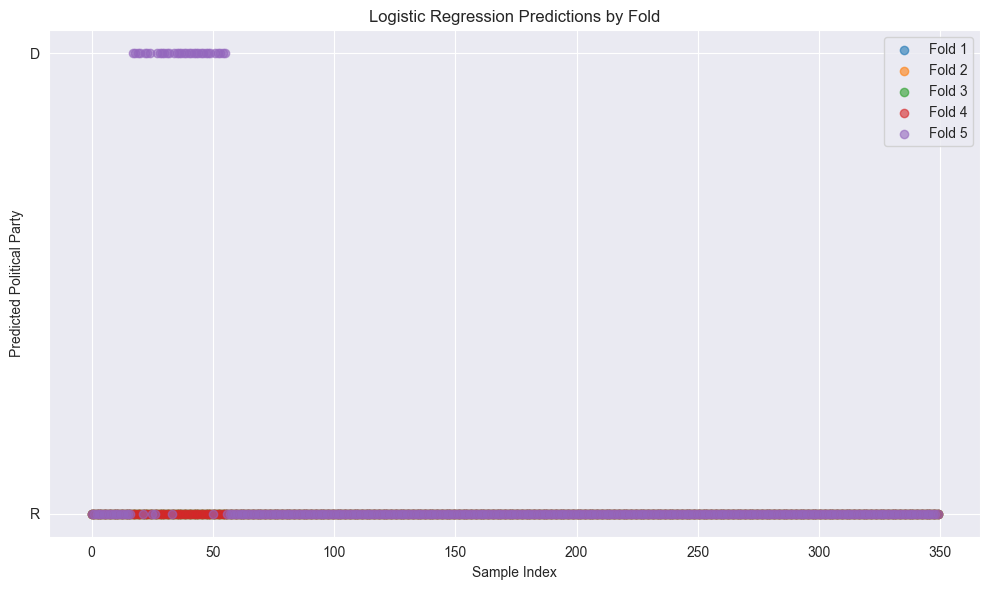


Average Accuracy Across Folds: 0.5697

Average Feature Coefficients Across All Folds:
               Feature  Mean Coefficient  Std Deviation
2  emissions_t_minus_1         -0.011286       0.010070
1  emissions_t_minus_2          0.006816       0.003212
0  emissions_t_minus_3          0.004811       0.009099

Non-Lag Feature Coefficients (Excludes emissions_t_minus_X):
Empty DataFrame
Columns: [Feature, Mean Coefficient, Std Deviation]
Index: []

Stratified Accuracy (average across states): 0.5873
Highest Accuracy State: UT (1.0000)
Lowest Accuracy State: TN (0.0000)


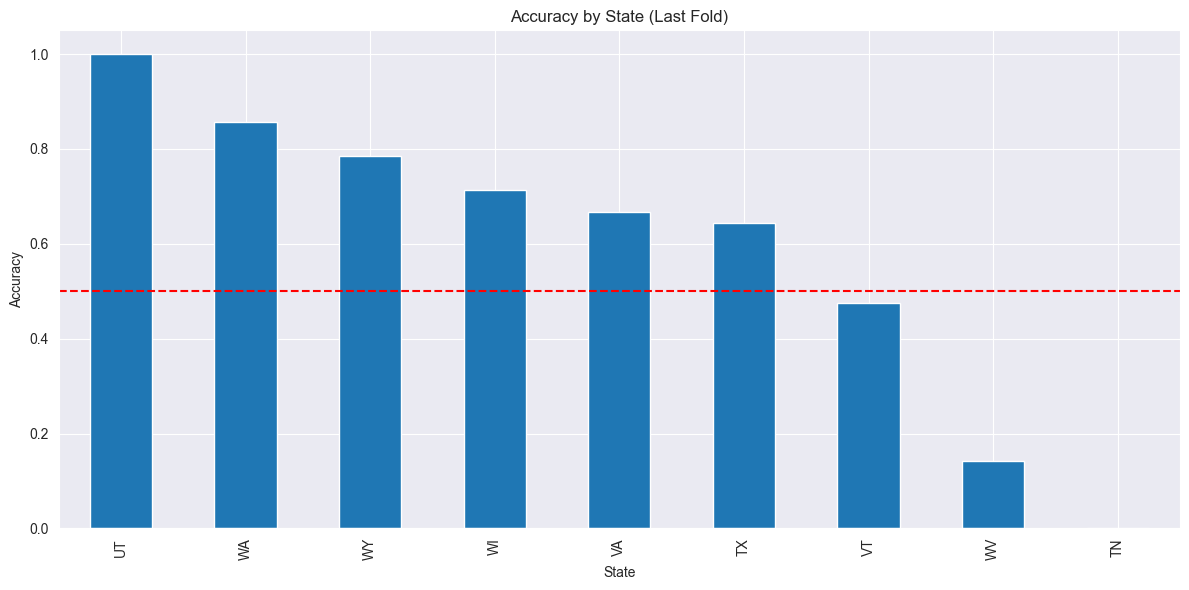


Top Feature Frequency (Percent of States Where Each Feature Was Most Predictive):
emissions_t_minus_3    50.000000
emissions_t_minus_1    33.333333
emissions_t_minus_2    16.666667
dtype: float64


([0.58,
  0.4828571428571429,
  0.5857142857142857,
  0.5657142857142857,
  0.6342857142857142],
                Feature  Mean Coefficient  Std Deviation
 2  emissions_t_minus_1         -0.011286       0.010070
 1  emissions_t_minus_2          0.006816       0.003212
 0  emissions_t_minus_3          0.004811       0.009099,
 Empty DataFrame
 Columns: [Feature, Mean Coefficient, Std Deviation]
 Index: [],
 0.5873015873015873,
 state
 UT    1.000000
 WA    0.857143
 WY    0.785714
 WI    0.714286
 VA    0.666667
 TX    0.642857
 VT    0.476190
 WV    0.142857
 TN    0.000000
 dtype: float64,
 emissions_t_minus_3    50.000000
 emissions_t_minus_1    33.333333
 emissions_t_minus_2    16.666667
 dtype: float64)

In [41]:
train_logistic_regression_forecasting(final_df_normalized_tmp, exclude_demo_features=True)

#### Engineered Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_feature_engineered_lr(df, window_size=3, n_splits=5, use_ridge=False, ridge_alpha=1.0):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'emissions_per_capita' not in df.columns:
            print("Required columns ('state', 'emissions_per_capita') are missing.")
            return

        # Create lagged emissions_per_capita features
        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions_per_capita']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions_per_capita': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + ['population_density']
        X = df[features]
        y = df['party_affiliation_score']
        states = df['state']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores, mse_scores, explained_scores = [], [], []
        coefs_all_folds, top_feature_counts = [], []

        plt.figure(figsize=(10, 6))

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            states_test = states.iloc[test_idx]

            model = Ridge(alpha=ridge_alpha) if use_ridge else LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            explained_var = explained_variance_score(y_test, y_pred)

            print(f"Fold {fold} — R²: {r2:.4f}, MSE: {mse:.4f}, Explained Variance: {explained_var:.4f}")
            r2_scores.append(r2)
            mse_scores.append(mse)
            explained_scores.append(explained_var)
            coefs_all_folds.append(model.coef_)

            plt.scatter(y_test, y_pred, label=f'Fold {fold}', alpha=0.6)

            # Feature importance tracking per state
            fold_df = df.iloc[test_idx].copy()
            for state, group in fold_df.groupby('state'):
                if len(group) < window_size + 3:
                    continue
                X_state = group[features]
                y_state = group['party_affiliation_score']
                model_state = Ridge(alpha=ridge_alpha) if use_ridge else LinearRegression()
                model_state.fit(X_state, y_state)
                coefs = pd.Series(model_state.coef_, index=features).abs()
                top_feature = coefs.idxmax()
                top_feature_counts.append(top_feature)

            if fold == n_splits:
                final_test_df = pd.DataFrame({
                    'state': states_test.values,
                    'actual': y_test.values,
                    'predicted': y_pred
                })

        min_val, max_val = min(y.min(), y.max()), max(y.min(), y.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
        plt.xlabel('Actual Party Affiliation Score')
        plt.ylabel('Predicted Score')
        plt.title('Feature Engineered Linear Regression' + (' (Ridge)' if use_ridge else ''))
        plt.legend(title='Fold')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nAverage R² Score: {np.mean(r2_scores):.4f}")
        print(f"Average Mean Squared Error: {np.mean(mse_scores):.4f}")
        print(f"Average Explained Variance Score: {np.mean(explained_scores):.4f}")

        coef_matrix = np.array(coefs_all_folds)
        mean_coefs = coef_matrix.mean(axis=0)
        std_coefs = coef_matrix.std(axis=0)

        coef_df = pd.DataFrame({
            'Feature': features,
            'Mean Coefficient': mean_coefs,
            'Std Deviation': std_coefs
        }).sort_values(by='Mean Coefficient', key=abs, ascending=False)

        print("\nAverage Feature Coefficients Across All Folds:")
        print(coef_df)

        r2_by_state = final_test_df.groupby('state').apply(lambda g: r2_score(g['actual'], g['predicted']))
        stratified_r2 = r2_by_state.mean()

        print(f"\nStratified R² (average across states): {stratified_r2:.4f}")
        print(f"Highest R² State: {r2_by_state.idxmax()} ({r2_by_state.max():.4f})")
        print(f"Lowest R² State: {r2_by_state.idxmin()} ({r2_by_state.min():.4f})")

        plt.figure(figsize=(12, 6))
        r2_by_state.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0, color='red', linestyle='--')
        plt.title('R² by State (Last Fold)')
        plt.xlabel('State')
        plt.ylabel('R² Score')
        plt.tight_layout()
        plt.show()

        total_state_models = len(top_feature_counts)
        top_emissions_pct = (sum(f.startswith('emissions') for f in top_feature_counts) / total_state_models) * 100

        print(f"\nPercentage of state models where an 'emissions_t_minus_X' feature was most predictive: {top_emissions_pct:.2f}%")

        return r2_scores, mse_scores, explained_scores, coef_df, stratified_r2, r2_by_state.sort_values(ascending=False), top_emissions_pct

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


Shape after sliding window processing: (2100, 8)
Fold 1 — R²: -4.2148, MSE: 0.3313, Explained Variance: -4.2122
Fold 2 — R²: -0.1077, MSE: 0.0638, Explained Variance: -0.0086
Fold 3 — R²: 0.0280, MSE: 0.0563, Explained Variance: 0.0603
Fold 4 — R²: -0.0676, MSE: 0.0523, Explained Variance: -0.0618
Fold 5 — R²: -0.2620, MSE: 0.0723, Explained Variance: -0.2567


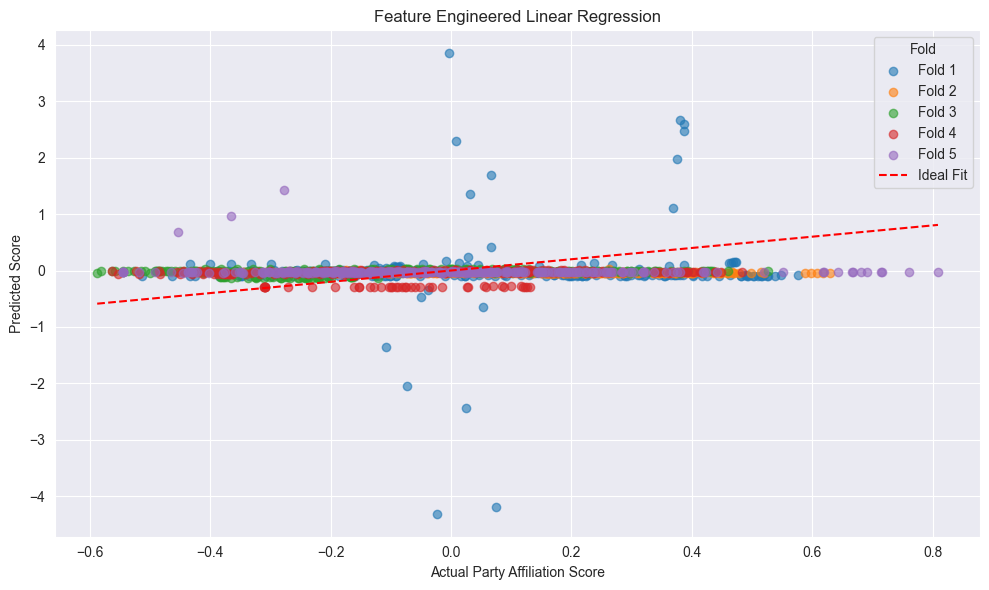


Average R² Score: -0.9248
Average Mean Squared Error: 0.1152
Average Explained Variance Score: -0.8958

Average Feature Coefficients Across All Folds:
               Feature  Mean Coefficient  Std Deviation
3   population_density          0.000580       0.004697
0  emissions_t_minus_3          0.000003       0.000004
1  emissions_t_minus_2          0.000002       0.000004
2  emissions_t_minus_1          0.000002       0.000003

Stratified R² (average across states): -1.5467
Highest R² State: VT (-0.0042)
Lowest R² State: TN (-5.6419)


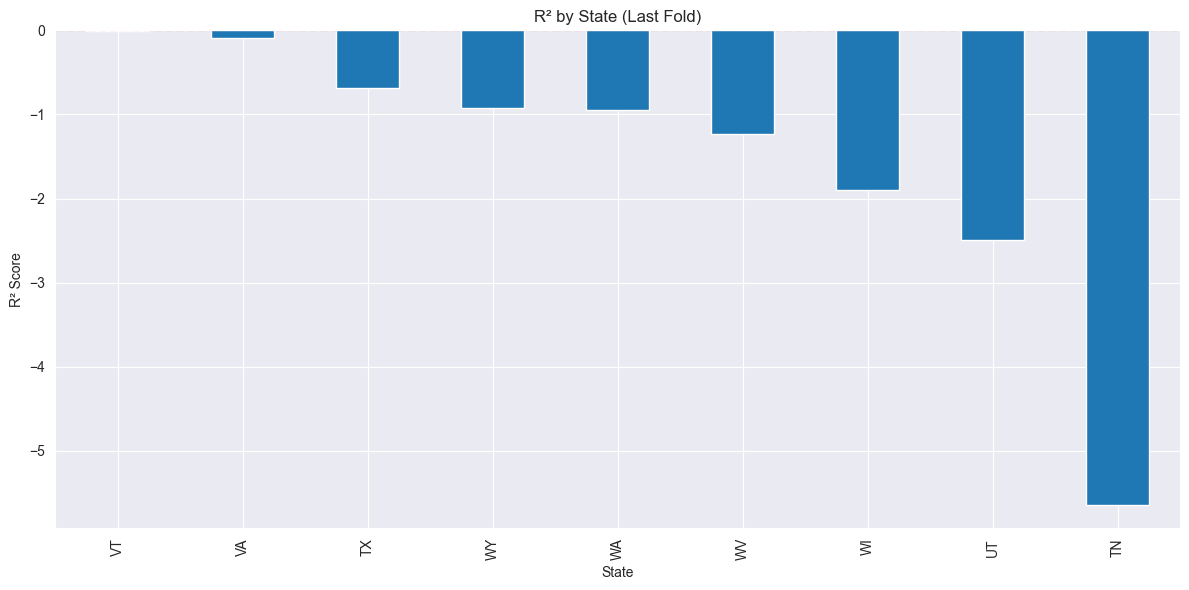


Percentage of state models where an 'emissions_t_minus_X' feature was most predictive: 0.00%


In [43]:
results = train_feature_engineered_lr(df_modified_normalized)

### Random Forest

In [44]:
final_df_tmp = final_df
final_df_tmp['political_party'] = final_df['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_tmp

,year,state,emissions,population,size,party_affiliation_score,political_party
0,1976,AL,107.172609,-0.260609,-0.244045,0.707140,D
1,1977,AL,107.172609,-0.260609,-0.244045,0.707140,D
2,1978,AL,107.172609,-0.260609,-0.244045,0.707140,D
3,1979,AL,107.172609,-0.260609,-0.244045,0.707140,D
4,1980,AL,107.172609,-0.260609,-0.244045,0.707140,D
...,...,...,...,...,...,...,...
2245,2016,WY,61.035090,-0.808000,0.227085,-0.280461,R
2246,2017,WY,59.622609,-0.808312,0.227085,-0.287553,R
2247,2018,WY,58.210128,-0.808624,0.227085,-0.294644,R
2248,2019,WY,56.797646,-0.808936,0.227085,-0.301735,R


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_random_forest_classification_forecasting(
    df,
    window_size=3,
    n_splits=5,
    n_estimators=100,
    max_depth=None,
    exclude_demo_features=False
):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'political_party' not in df.columns:
            print("Required columns ('state', 'political_party') are missing.")
            return

        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        base_features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)]
        extra_features = [] if exclude_demo_features else ['population', 'size']
        features = base_features + extra_features

        X = df[features]
        y = df['political_party']
        states = df['state']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        accuracy_scores = []
        feature_importances_all_folds = []
        top_feature_counts = []

        plt.figure(figsize=(10, 6))

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            states_test = states.iloc[test_index]

            if len(np.unique(y_train)) < 2:
                print(f"Fold {fold} skipped — only one class ({np.unique(y_train)[0]}) present in training data.")
                continue

            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            accuracy_scores.append(acc)
            feature_importances_all_folds.append(model.feature_importances_)

            print(f"Fold {fold} — Accuracy: {acc:.4f}")
            plt.scatter(range(len(y_test)), y_pred, alpha=0.6, label=f'Fold {fold}')

            fold_df = df.iloc[test_index].copy()
            for state, group in fold_df.groupby('state'):
                if len(group) < window_size + 3:
                    continue
                X_state = group[features]
                y_state = group['political_party']
                if len(np.unique(y_state)) < 2:
                    continue
                model_state = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
                model_state.fit(X_state, y_state)
                importances = pd.Series(model_state.feature_importances_, index=features)
                top_feature = importances.idxmax()
                top_feature_counts.append(top_feature)

            if fold == n_splits:
                final_test_df = pd.DataFrame({
                    'state': states_test.values,
                    'actual': y_test.values,
                    'predicted': y_pred
                })

        plt.xlabel('Sample Index')
        plt.ylabel('Predicted Political Party')
        plt.title('Random Forest Predictions by Fold')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if not accuracy_scores:
            print("\nNo valid folds with both classes. Cannot compute overall metrics.")
            return None

        print(f"\nAverage Accuracy Across Folds: {np.mean(accuracy_scores):.4f}")

        feature_importances_matrix = np.array(feature_importances_all_folds)
        mean_importances = feature_importances_matrix.mean(axis=0)
        std_importances = feature_importances_matrix.std(axis=0)

        feature_df = pd.DataFrame({
            'Feature': features,
            'Mean Importance': mean_importances,
            'Std Deviation': std_importances
        }).sort_values(by='Mean Importance', ascending=False)

        print("\nAverage Feature Importances Across All Folds:")
        print(feature_df)

        # Filter to show only non-lag features
        non_lag_df = feature_df[~feature_df['Feature'].str.startswith('emissions_t_minus_')]
        print("\nNon-Lag Feature Importances (Excludes emissions_t_minus_X):")
        print(non_lag_df)

        accuracy_by_state = final_test_df.groupby('state').apply(lambda g: accuracy_score(g['actual'], g['predicted']))
        stratified_accuracy = accuracy_by_state.mean()

        print(f"\nStratified Accuracy (average across states): {stratified_accuracy:.4f}")
        print(f"Highest Accuracy State: {accuracy_by_state.idxmax()} ({accuracy_by_state.max():.4f})")
        print(f"Lowest Accuracy State: {accuracy_by_state.idxmin()} ({accuracy_by_state.min():.4f})")

        plt.figure(figsize=(12, 6))
        accuracy_by_state.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0.5, color='red', linestyle='--')
        plt.title('Accuracy by State (Last Fold)')
        plt.xlabel('State')
        plt.ylabel('Accuracy')
        plt.tight_layout()
        plt.show()

        total_state_models = len(top_feature_counts)
        top_feature_counts_series = pd.Series(top_feature_counts)
        top_feature_counts_percent = top_feature_counts_series.value_counts(normalize=True) * 100

        print("\nTop Feature Frequency (Percent of States Where Each Feature Was Most Predictive):")
        print(top_feature_counts_percent)

        return (
            accuracy_scores,
            feature_df,
            non_lag_df,
            stratified_accuracy,
            accuracy_by_state.sort_values(ascending=False),
            top_feature_counts_percent
        )

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


Shape after sliding window processing: (2100, 10)
Fold 1 — Accuracy: 0.5743
Fold 2 — Accuracy: 0.5029
Fold 3 — Accuracy: 0.5114
Fold 4 — Accuracy: 0.5629
Fold 5 — Accuracy: 0.6171


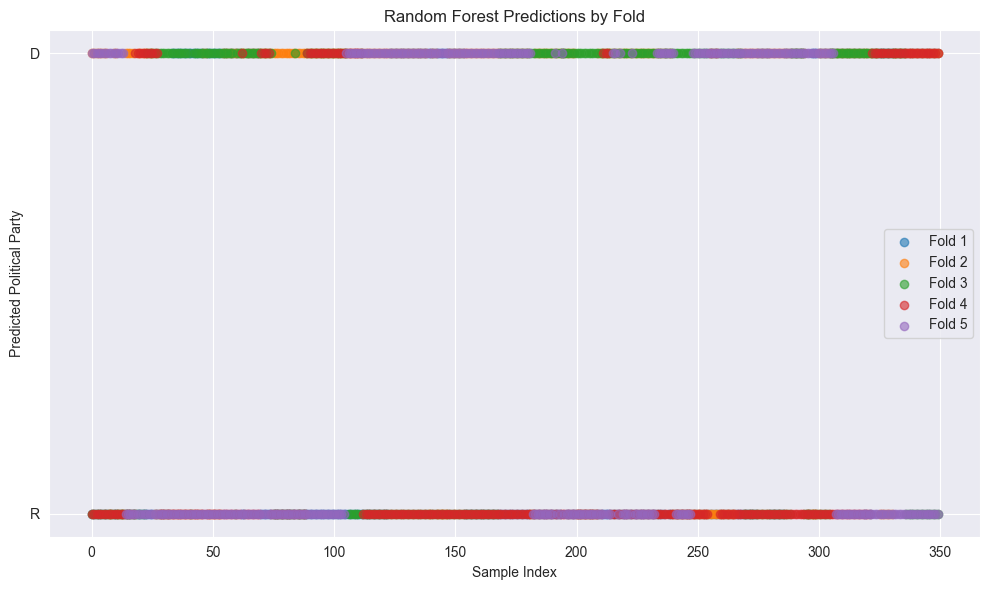


Average Accuracy Across Folds: 0.5537

Average Feature Importances Across All Folds:
               Feature  Mean Importance  Std Deviation
3           population         0.296093       0.027495
4                 size         0.194465       0.042340
2  emissions_t_minus_1         0.176942       0.011750
1  emissions_t_minus_2         0.168937       0.013491
0  emissions_t_minus_3         0.163562       0.012857

Non-Lag Feature Importances (Excludes emissions_t_minus_X):
      Feature  Mean Importance  Std Deviation
3  population         0.296093       0.027495
4        size         0.194465       0.042340

Stratified Accuracy (average across states): 0.6455
Highest Accuracy State: TN (1.0000)
Lowest Accuracy State: TX (0.2143)


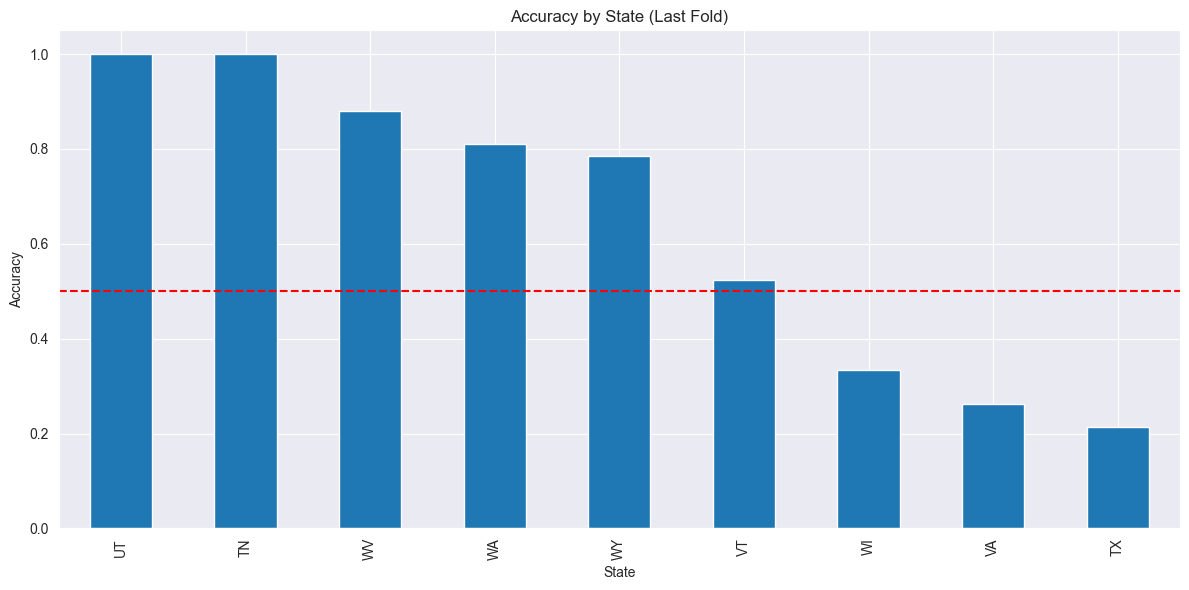


Top Feature Frequency (Percent of States Where Each Feature Was Most Predictive):
population             66.666667
emissions_t_minus_3    13.888889
emissions_t_minus_2    11.111111
emissions_t_minus_1     8.333333
dtype: float64


([0.5742857142857143,
  0.5028571428571429,
  0.5114285714285715,
  0.5628571428571428,
  0.6171428571428571],
                Feature  Mean Importance  Std Deviation
 3           population         0.296093       0.027495
 4                 size         0.194465       0.042340
 2  emissions_t_minus_1         0.176942       0.011750
 1  emissions_t_minus_2         0.168937       0.013491
 0  emissions_t_minus_3         0.163562       0.012857,
       Feature  Mean Importance  Std Deviation
 3  population         0.296093       0.027495
 4        size         0.194465       0.042340,
 0.6455026455026455,
 state
 UT    1.000000
 TN    1.000000
 WV    0.880952
 WA    0.809524
 WY    0.785714
 VT    0.523810
 WI    0.333333
 VA    0.261905
 TX    0.214286
 dtype: float64,
 population             66.666667
 emissions_t_minus_3    13.888889
 emissions_t_minus_2    11.111111
 emissions_t_minus_1     8.333333
 dtype: float64)

In [46]:
train_random_forest_classification_forecasting(final_df_tmp)